## Applying an AdaBoost Model to classify and predict bike purchase.
## This is a bike company's data on purchases of bike by its customers.The features include several customer characteristics like income, average monthly spending, education, age, gender, marital status, number of children, homeownership etc.

In [3]:
# Install the following packages

from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import numpy.random as nr
import seaborn as sns  

%matplotlib inline

In [4]:
data = pd.read_csv('AW_data.csv')
data.head()
data = data.dropna()
print(data.shape)
print(list(data.columns))

(16519, 13)
['CustomerID', 'BikeBuyer', 'Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'Age', 'YearlyIncome', 'AveMonthSpend']


In [5]:
#Dropping the duplicates
data.drop_duplicates(subset = 'CustomerID', keep = 'first', inplace = True)
print(data.shape)
print(data.CustomerID.unique().shape) 

(16404, 13)
(16404,)


In [10]:
data.head()

,CustomerID,BikeBuyer,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,Age,YearlyIncome,AveMonthSpend
0,11000,0,Bachelors,Professional,M,M,1,0,0,2,32,137947,89
1,11001,1,Bachelors,Professional,M,S,0,1,3,3,33,101141,117
2,11002,0,Bachelors,Professional,M,M,1,1,3,3,33,91945,123
3,11003,0,Bachelors,Professional,F,S,0,1,0,0,30,86688,50
4,11004,1,Bachelors,Professional,F,S,1,4,5,5,30,92771,95


## Some data visualizations first.

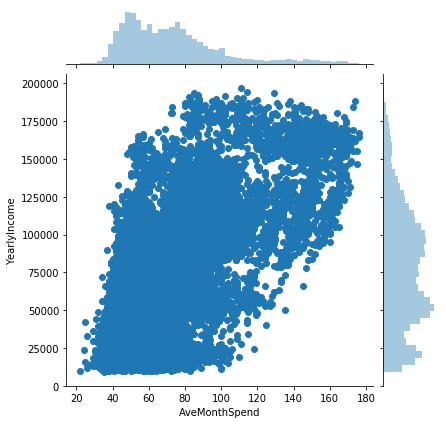

In [7]:
#Joint Plot
sns.jointplot(x = data['AveMonthSpend'], y = data['YearlyIncome'])

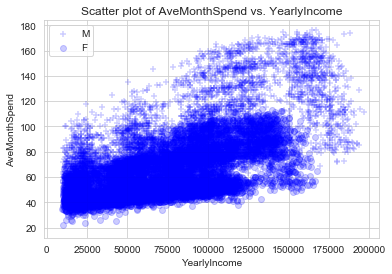

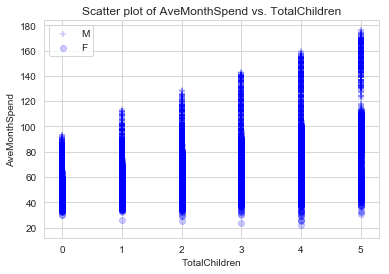

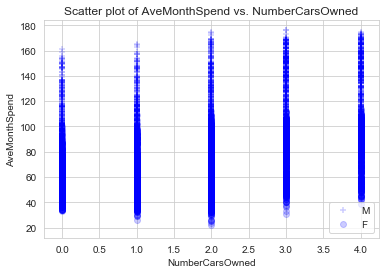

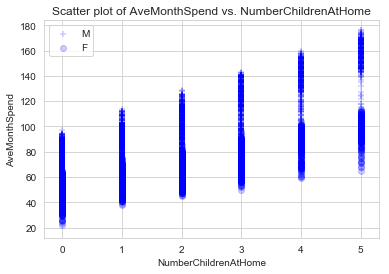

In [8]:
## Scatter plots

def plot_scatter_shape(data, cols, shape_col = 'Gender', col_y = 'AveMonthSpend', alpha = 0.2):
    shapes = ['+', 'o', 's', 'x', '^'] # pick distinctive shapes
    unique_cats = data[shape_col].unique()
    for col in cols: # loop over the columns to plot
        sns.set_style("whitegrid")
        for i, cat in enumerate(unique_cats): # loop over the unique categories
            temp = data[data[shape_col] == cat]
            sns.regplot(col, col_y, data=temp, marker = shapes[i], label = cat,
                        scatter_kws={"alpha":alpha}, fit_reg = False, color = 'blue')
        plt.title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.legend()
        plt.show()
            
num_cols = ['YearlyIncome', 'TotalChildren', 'NumberCarsOwned', 'NumberChildrenAtHome']
plot_scatter_shape(data, num_cols) 

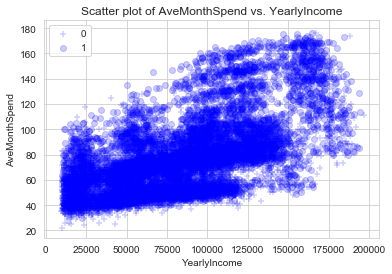

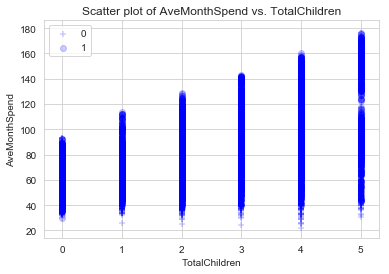

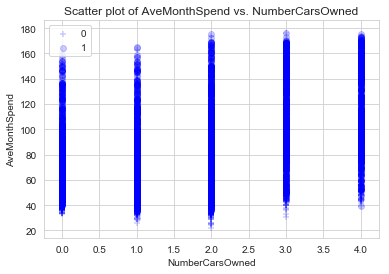

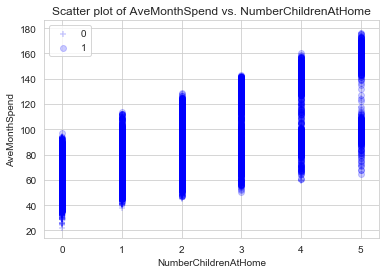

In [9]:
def plot_scatter_shape(aw, cols, shape_col = 'BikeBuyer', col_y = 'AveMonthSpend', alpha = 0.2):
    shapes = ['+', 'o', 's', 'x', '^'] # pick distinctive shapes
    unique_cats = data[shape_col].unique()
    for col in cols: # loop over the columns to plot
        sns.set_style("whitegrid")
        for i, cat in enumerate(unique_cats): # loop over the unique categories
            temp = data[data[shape_col] == cat]
            sns.regplot(col, col_y, data=temp, marker = shapes[i], label = cat,
                        scatter_kws={"alpha":alpha}, fit_reg = False, color = 'blue')
        plt.title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.legend()
        plt.show()
            
num_cols = ['YearlyIncome', 'TotalChildren', 'NumberCarsOwned', 'NumberChildrenAtHome']
plot_scatter_shape(data, num_cols) 

## Description of the data types 

In [6]:
data.dtypes

CustomerID               int64
BikeBuyer                int64
Education               object
Occupation              object
Gender                  object
MaritalStatus           object
HomeOwnerFlag            int64
NumberCarsOwned          int64
NumberChildrenAtHome     int64
TotalChildren            int64
Age                      int64
YearlyIncome             int64
AveMonthSpend            int64
dtype: object

## Coverting both Gender and Marital status into binary variables. 

In [11]:
def convert_M_F(txt):
    if 'M' in txt:
        return 1
    else:
        return 0

In [12]:
data.Gender = data.Gender.apply(convert_M_F)

In [13]:
def convert_M_S(txt):
    if 'M' in txt:
        return 1
    else:
        return 0

In [14]:
data.MaritalStatus = data.MaritalStatus.apply(convert_M_S) 

In [15]:
data.head()

,CustomerID,BikeBuyer,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,Age,YearlyIncome,AveMonthSpend
0,11000,0,Bachelors,Professional,1,1,1,0,0,2,32,137947,89
1,11001,1,Bachelors,Professional,1,0,0,1,3,3,33,101141,117
2,11002,0,Bachelors,Professional,1,1,1,1,3,3,33,91945,123
3,11003,0,Bachelors,Professional,0,0,0,1,0,0,30,86688,50
4,11004,1,Bachelors,Professional,0,0,1,4,5,5,30,92771,95


## Next we will do one-hot encoding for the categorical variables that have multiple levels.

In [16]:
## We will use the get dummies code.
data= pd.get_dummies(data)

In [17]:
data.head()

,CustomerID,BikeBuyer,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,Age,YearlyIncome,...,Education_Bachelors,Education_Graduate Degree,Education_High School,Education_Partial College,Education_Partial High School,Occupation_Clerical,Occupation_Management,Occupation_Manual,Occupation_Professional,Occupation_Skilled Manual
0,11000,0,1,1,1,0,0,2,32,137947,...,1,0,0,0,0,0,0,0,1,0
1,11001,1,1,0,0,1,3,3,33,101141,...,1,0,0,0,0,0,0,0,1,0
2,11002,0,1,1,1,1,3,3,33,91945,...,1,0,0,0,0,0,0,0,1,0
3,11003,0,0,0,0,1,0,0,30,86688,...,1,0,0,0,0,0,0,0,1,0
4,11004,1,0,0,1,4,5,5,30,92771,...,1,0,0,0,0,0,0,0,1,0


In [18]:
print(data.shape)
print(list(data.columns))

(16404, 21)
['CustomerID', 'BikeBuyer', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'Age', 'YearlyIncome', 'AveMonthSpend', 'Education_Bachelors ', 'Education_Graduate Degree', 'Education_High School', 'Education_Partial College', 'Education_Partial High School', 'Occupation_Clerical', 'Occupation_Management', 'Occupation_Manual', 'Occupation_Professional', 'Occupation_Skilled Manual']


## Show counts of customers who purchased bikes vs. who did not.

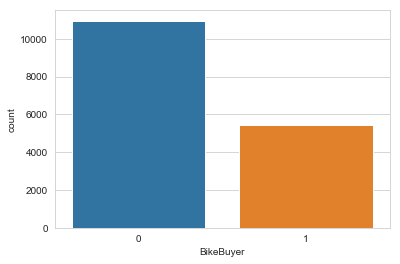

In [20]:
sns.countplot(x = 'BikeBuyer', data = data)  

## Next we create a numpy array of the features and label.

In [22]:
Features = np.array(data[['Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'Age', 'YearlyIncome', 'AveMonthSpend', 'Education_Bachelors ', 'Education_Graduate Degree', 'Education_High School', 'Education_Partial College', 'Education_Partial High School', 'Occupation_Clerical', 'Occupation_Management', 'Occupation_Manual', 'Occupation_Professional', 'Occupation_Skilled Manual']])
Labels =  np.array(data[['BikeBuyer']])  

In [23]:
# Split the dataset into test and training set
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 13123)  # 80% of the data is in the test dataset.
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Standardize the dataset using zscore method. 

In [26]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)

C:\Users\Amit Ghosh.SFH-315-0605\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Amit Ghosh.SFH-315-0605\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Define and fit an AdaBoost tree model.

In [27]:
# Fit the model with 100 estimators (trees) using the AdaBoostClassifer function from the Scikit Learn ensemble package.

nr.seed(1115)
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

## Next we score the test data subset.
## The test features are scaled using the scaler computed for the training features. Then the predict method is used to compute the scores from the scaled features.

In [28]:
X_test = scale.transform(X_test)
scores = ab_clf.predict(X_test) 

C:\Users\Amit Ghosh.SFH-315-0605\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
## We evaluate the performance of the model.

def print_metrics_3(labels, scores):
   
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                  Score No Purchase   Score Purchase    ')
    print('Actual No Purchase      %6d' % conf[0,0] + '            %5d' % conf[0,1]   )            
    print('Actual Purchase         %6d' % conf[1,0] + '            %5d' % conf[1,1]   )
        ## Now compute and display the accuracy and metrics
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    print(' ')
    print('          No Purchase  Purchase  ')
    print('Num case    %0.2f' % metrics[3][0] + '     %0.2f' % metrics[3][1]         )
    print('Precision   %0.2f' % metrics[0][0] + '      %0.2f' % metrics[0][1]        )
    print('Recall      %0.2f' % metrics[1][0] + '      %0.2f' % metrics[1][1]        )
    print('F1          %0.2f' % metrics[2][0] + '      %0.2f' % metrics[2][1]        ) 
    
print_metrics_3(y_test, scores)

                 Confusion matrix
                  Score No Purchase   Score Purchase    
Actual No Purchase        7675             1104
Actual Purchase           1661             2683

Accuracy        0.79
 
          No Purchase  Purchase  
Num case    8779.00     4344.00
Precision   0.82      0.71
Recall      0.87      0.62
F1          0.85      0.66


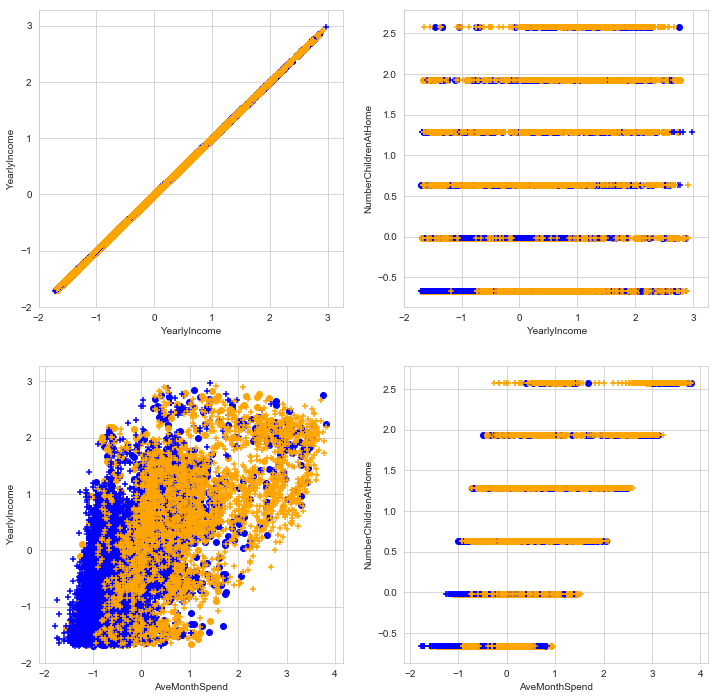

In [31]:
# Displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases

def plot_data_score(data, y_test, scores):
    '''Function to plot data data by type'''
    ## Find correctly and incorrectly classified cases
    true = np.equal(scores, y_test).astype(int)
    
    ## Create data frame from the test data
    data = pd.DataFrame(data)
    levels = {0:'No Purchase', 1:'Purchase'}
    data['BikeBuyer'] = [levels[x] for x in y_test]
    data.columns = ['Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'Age', 'YearlyIncome', 'AveMonthSpend', 'Education_Bachelors ', 'Education_Graduate Degree', 'Education_High School', 'Education_Partial College', 'Education_Partial High School', 'Occupation_Clerical', 'Occupation_Management', 'Occupation_Manual', 'Occupation_Professional', 'Occupation_Skilled Manual', 'BikeBuyer']
    
    ## Set up for the plot
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    markers = ['o', '+']
    x_ax = ['YearlyIncome', 'AveMonthSpend']
    y_ax = ['YearlyIncome', 'NumberChildrenAtHome']
    
    for t in range(2): # loop over correct and incorect classifications
        NoPurchase = data[(data['BikeBuyer'] == 'No Purchase') & (true == t)]
        Purchase = data[(data['BikeBuyer'] == 'Purchase') & (true == t)]
        
        # loop over all the dimensions
        for i in range(2):
            for j in range(2):
                ax[i,j].scatter(NoPurchase[x_ax[i]], NoPurchase[y_ax[j]], marker = markers[t], color = 'blue')
                ax[i,j].scatter(Purchase[x_ax[i]], Purchase[y_ax[j]], marker = markers[t], color = 'orange')
                ax[i,j].set_xlabel(x_ax[i])
                ax[i,j].set_ylabel(y_ax[j])

plot_data_score(X_test, y_test, scores)

## Now we will check for feature importance and then display its plot. 

Text(0, 0.5, 'Feature importance')

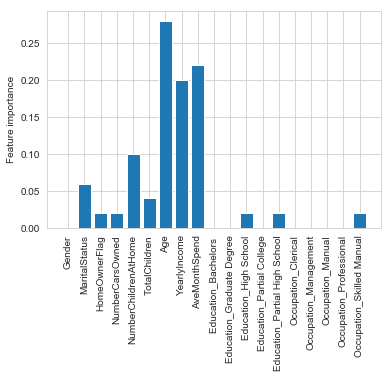

In [32]:
# Display a plot of the feature importance

importance = ab_clf.feature_importances_
plt.bar(range(19), importance, tick_label = ['Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'Age', 'YearlyIncome', 'AveMonthSpend', 'Education_Bachelors ', 'Education_Graduate Degree', 'Education_High School', 'Education_Partial College', 'Education_Partial High School', 'Occupation_Clerical', 'Occupation_Management', 'Occupation_Manual', 'Occupation_Professional', 'Occupation_Skilled Manual'])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')

## Next we create a model with a reduced feature set by dropping some of the features that are not important. 

In [33]:
# As a first step, we create training and test datasets using the reduced features.

## Create reduced feature set
Features = np.array(data[['MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'Age', 'YearlyIncome', 'AveMonthSpend', 'Education_High School', 'Education_Partial High School', 'Occupation_Skilled Manual']])

## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 13123)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Next we define this model with reduced features, fit the model, score the model and print the results. 

In [34]:
nr.seed(1115)
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
scores = ab_clf.predict(X_test)
print_metrics_3(y_test, scores)

                 Confusion matrix
                  Score No Purchase   Score Purchase    
Actual No Purchase        7675             1104
Actual Purchase           1661             2683

Accuracy        0.79
 
          No Purchase  Purchase  
Num case    8779.00     4344.00
Precision   0.82      0.71
Recall      0.87      0.62
F1          0.85      0.66


## Dropping some of the features does not improve model accuracy. However, here we have used 80% of our dataset as test. Increasing the share of the train dataste will increase model acuracy. We sho this below using 60% training dataset.

In [45]:
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 6561)  # 80% of the data is in the train dataset.
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [46]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train) 

C:\Users\Amit Ghosh.SFH-315-0605\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Amit Ghosh.SFH-315-0605\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
 ## Fit the model with 100 estimators (trees) using the AdaBoostClassifer function.

nr.seed(1115)
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
X_test = scale.transform(X_test)
scores = ab_clf.predict(X_test) 
print_metrics_3(y_test, scores)  

                 Confusion matrix
                  Score No Purchase   Score Purchase    
Actual No Purchase        3846              515
Actual Purchase            824             1376

Accuracy        0.80
 
          No Purchase  Purchase  
Num case    4361.00     2200.00
Precision   0.82      0.73
Recall      0.88      0.63
F1          0.85      0.67


C:\Users\Amit Ghosh.SFH-315-0605\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
